In [2]:
! pip install verde harmonica pandas matplotlib

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd
import pandas as pd

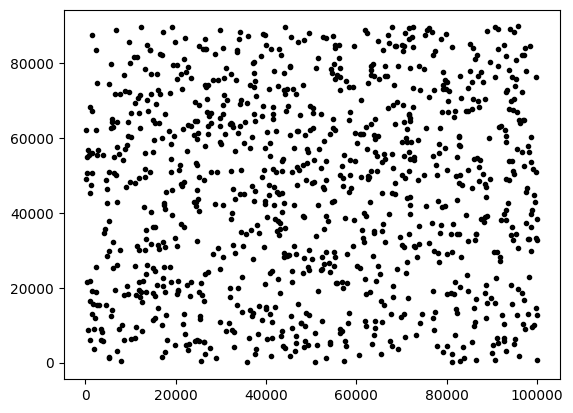

In [4]:
region = [0, 100e3, 0, 90e3]
coordinates = vd.scatter_points(region, size=1000, extra_coords=1000)

plt.plot(coordinates[0], coordinates[1], ".k")

In [5]:
len(coordinates[0])

1000

In [6]:
prismas = [
    [10e3, 15e3, 20e3, 35e3, -1e3,  0],
    [60e3, 80e3, 50e3, 70e3, -2e3,  -0.5e3],
]
densidades = [500, -300]
gz = hm.prism_gravity(coordinates, prismas, densidades, field="g_z")

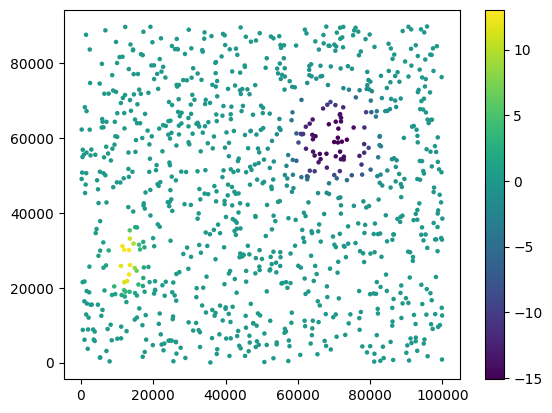

In [7]:
plt.scatter(coordinates[0], coordinates[1], s=5, c=gz)
plt.colorbar()

In [8]:
# Fontes equivalentes
fontes = hm.EquivalentSourcesGB(damping=1,depth=1e3)
altura = np.zeros(1000)
fontes.fit([coordinates[0],coordinates[1],altura],data=gz) # o que faz essa funcao .fit?

EquivalentSourcesGB(damping=1, depth=1000.0)

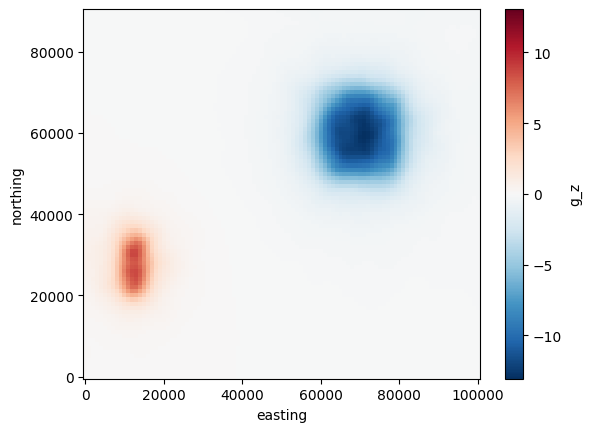

In [9]:
grid_coords_eq = vd.grid_coordinates(region,spacing=1e3,extra_coords=1000)
gz_grid_eq = fontes.grid(grid_coords_eq,data_names="g_z")
gz_grid_eq.g_z.plot()

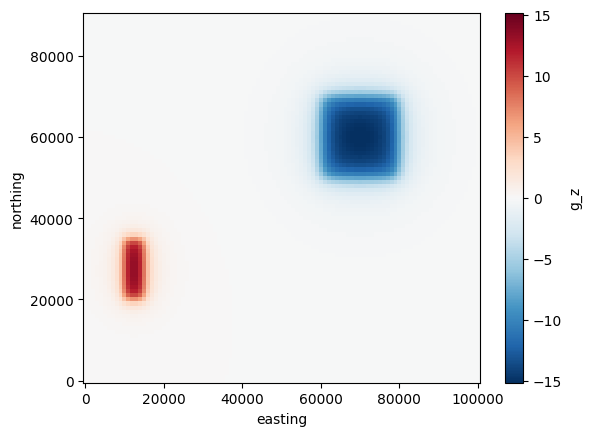

In [10]:
# Malha regular
grid_coords = vd.grid_coordinates(region, spacing=1e3, extra_coords=1000)
gz_grid = hm.prism_gravity(grid_coords, prismas, densidades, field="g_z")
grid_true = vd.make_xarray_grid(grid_coords, gz_grid, data_names="g_z", extra_coords_names="upward")
grid_true.g_z.plot()


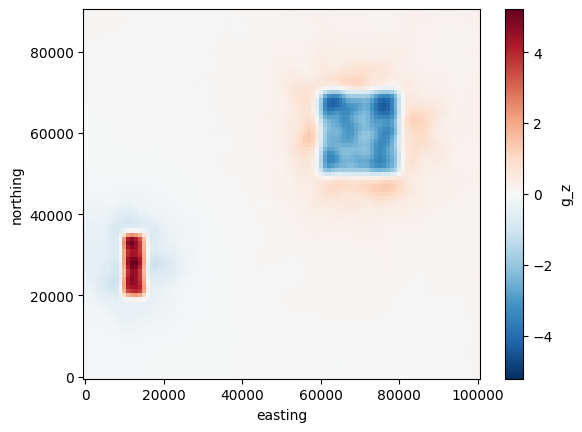

In [11]:
# Diferença
dif = grid_true - gz_grid_eq
dif.g_z.plot()

In [12]:
# Using cross-validation to evaluate how well 
# these equivalent sources can accurately predict the values of the field
score_first_guess = np.mean(
    vd.cross_val_score(
        fontes,
        coordinates,
        gz,
    )
)
R_2 = score_first_guess
R_2

C:\Users\skill\miniforge3\lib\site-packages\verde\model_selection.py:784: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  score = estimator.score(*test_data)
C:\Users\skill\miniforge3\lib\site-packages\verde\model_selection.py:784: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  score = estimator.score(*test_data)
C:\Users\skill\miniforge3\lib\site-packages\verde\model_selection.py:784: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  score = estimator.score(*test_data)
C:\Users\skill\miniforge3\lib\site-packages\verde\model_selection.py:784: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) 

0.9536368907804524

In [13]:
# Block-averaged sources
# This method divides the survey region (defined by the data) into square blocks of equal size, 
# computes the median coordinates of the data points that fall inside each block and 
# locates one source beneath every averaged position. This way, we define one equivalent source per block, 
# with the exception of empty blocks that won’t get any source.

fontes_block = hm.EquivalentSourcesGB(damping=1,depth=1e3,block_size=500, depth_type="constant")
# These sources were set at a constant depth of 1km bellow the zeroth height and with a damping equal to 1.

fontes_block.fit([coordinates[0],coordinates[1],altura],data=gz)
# During this step the point sources are created through the block averaging process.

C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:179: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:236: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)


EquivalentSourcesGB(block_size=500, damping=1, depth=1000.0,
                    depth_type='constant')

In [14]:
# Using cross-validation to evaluate how well 
# these equivalent sources can accurately predict the values of the field
score_first_guess = np.mean(
    vd.cross_val_score(
        fontes_block,
        coordinates,
        gz,
    )
)
R_2 = score_first_guess
# Bloco de 500m
print(f"Number of sources = {fontes_block.points_[0].size}")
print(f"R_2 = {R_2}")

C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:179: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:236: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)
C:\Users\skill\miniforge3\lib\site-packages\verde\model_selection.py:784: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selec

Number of sources = 990
R_2 = 0.9814827020187336


C:\Users\skill\miniforge3\lib\site-packages\verde\model_selection.py:784: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  score = estimator.score(*test_data)


In [15]:
# Blocos de 1000m
fontes_block = hm.EquivalentSourcesGB(damping=1,depth=1e3,block_size=1e3, depth_type="constant")
# These sources were set at a constant depth of 1km bellow the zeroth height and with a damping equal to 1.

fontes_block.fit([coordinates[0],coordinates[1],altura],data=gz)
# During this step the point sources are created through the block averaging process.


# Using cross-validation to evaluate how well 
# these equivalent sources can accurately predict the values of the field
score_first_guess = np.mean(
    vd.cross_val_score(
        fontes_block,
        coordinates,
        gz,
    )
)
R_2 = score_first_guess
print(f"Number of sources = {fontes_block.points_[0].size}")
print(f"R_2 = {R_2}")

C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:179: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:236: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)
C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:179: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of p

Number of sources = 939
R_2 = 0.9817824403366062


C:\Users\skill\miniforge3\lib\site-packages\verde\model_selection.py:784: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  score = estimator.score(*test_data)


In [16]:
# Blocos de 2500m
fontes_block = hm.EquivalentSourcesGB(damping=1,depth=1e3,block_size=2.5e3, depth_type="constant")
# These sources were set at a constant depth of 1km bellow the zeroth height and with a damping equal to 1.

fontes_block.fit([coordinates[0],coordinates[1],altura],data=gz)
# During this step the point sources are created through the block averaging process.


# Using cross-validation to evaluate how well 
# these equivalent sources can accurately predict the values of the field
score_first_guess = np.mean(
    vd.cross_val_score(
        fontes_block,
        coordinates,
        gz,
    )
)
R_2 = score_first_guess
print(f"Number of sources = {fontes_block.points_[0].size}")
print(f"R_2 = {R_2}")

C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:179: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:236: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)
C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:179: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of p

Number of sources = 728
R_2 = 0.9792568173304611


C:\Users\skill\miniforge3\lib\site-packages\verde\model_selection.py:784: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  score = estimator.score(*test_data)


In [17]:
# Blocos de 5000m
fontes_block = hm.EquivalentSourcesGB(damping=1,depth=1e3,block_size=5e3, depth_type="constant")
# These sources were set at a constant depth of 1km bellow the zeroth height and with a damping equal to 1.

fontes_block.fit([coordinates[0],coordinates[1],altura],data=gz)
# During this step the point sources are created through the block averaging process.


# Using cross-validation to evaluate how well 
# these equivalent sources can accurately predict the values of the field
score_first_guess = np.mean(
    vd.cross_val_score(
        fontes_block,
        coordinates,
        gz,
    )
)
R_2 = score_first_guess
print(f"Number of sources = {fontes_block.points_[0].size}")
print(f"R_2 = {R_2}")

C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:179: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:236: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)
C:\Users\skill\miniforge3\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(2, 3).
  warn(
C:\Users\skill\miniforge3\lib\site-packages\verde\base\leas

Number of sources = 345
R_2 = 0.9596401546715457


C:\Users\skill\miniforge3\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(2, 3).
  warn(
C:\Users\skill\miniforge3\lib\site-packages\verde\base\least_squares.py:57: UserWarning: Under-determined problem detected (ndata, nparams)=(1, 2).
  warn(
C:\Users\skill\miniforge3\lib\site-packages\verde\model_selection.py:784: FutureWarning: The default scoring will change from R² to negative root mean squared error (RMSE) in Verde 2.0.0. This may change model selection results slightly.
  score = estimator.score(*test_data)


In [18]:
R_2 = []
sources = []

block = [block for block in range(50,102050,2000)]
for block_size in block:
    fontes_block = hm.EquivalentSourcesGB(damping=1,depth=1e3,block_size=block_size, depth_type="constant")
    # These sources were set at a constant depth of 1km bellow the zeroth height and with a damping equal to 1.

    fontes_block.fit([coordinates[0],coordinates[1],altura],data=gz)
    # During this step the point sources are created through the block averaging process.

    # Using cross-validation to evaluate how well 
    # these equivalent sources can accurately predict the values of the field
    score = np.mean(
        vd.cross_val_score(
            fontes_block,
            coordinates,
            gz,
        )
    )
    R_2.append(score)
    sources.append(fontes_block.points_[0].size)


C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:179: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  blocked = pd.DataFrame(columns).groupby("block").aggregate(reduction)
C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:236: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  grouped = table.groupby("block").aggregate(self.reduction)
C:\Users\skill\miniforge3\lib\site-packages\verde\blockreduce.py:179: FutureWarning: The provided callable <function median at 0x000001CBC9143250> is currently using DataFrameGroupBy.median. In a future version of p

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Erro')

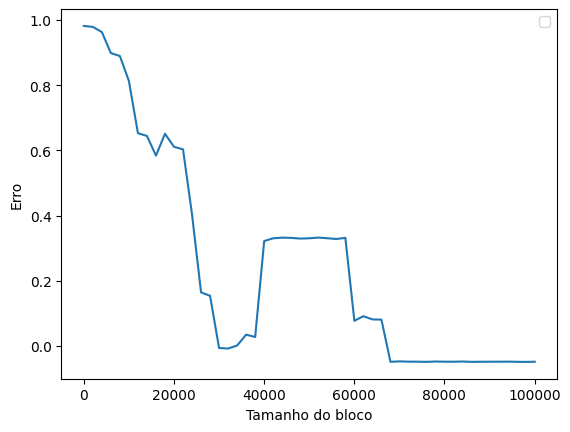

In [19]:
plt.plot(block,R_2)
plt.legend()
plt.xlabel('Tamanho do bloco')
plt.ylabel('Erro')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Erro')

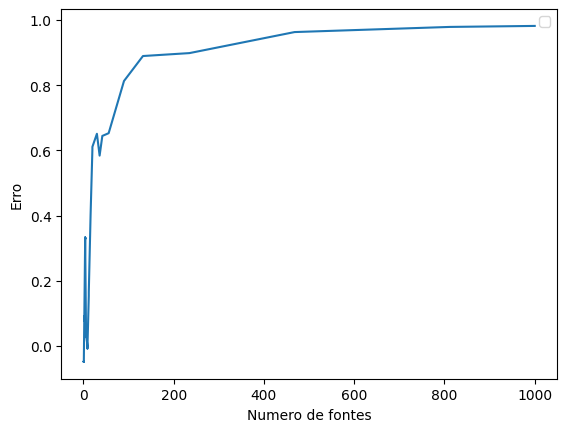

In [20]:
plt.plot(sources,R_2)
plt.legend()
plt.xlabel('Numero de fontes')
plt.ylabel('Erro')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Erro')

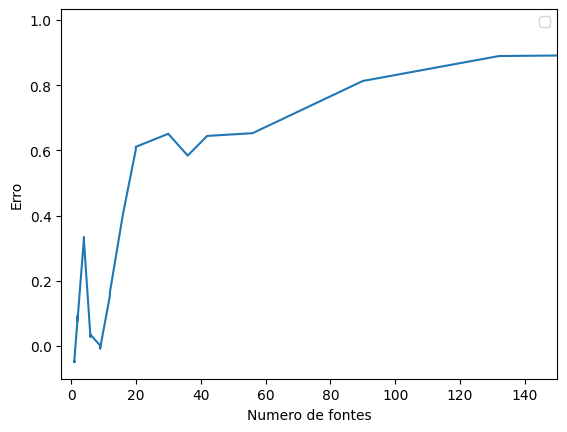

In [21]:
plt.plot(sources,R_2)
plt.legend()
plt.xlabel('Numero de fontes')
plt.xlim(-3,150)
plt.ylabel('Erro')

In [22]:
# Splitting data randomly into train and test sets

test_size = 0.2
# Assign 20% of the data to the testing set.

train, test = vd.train_test_split(
    coordinates, gz, test_size=test_size, random_state=123
)

print(f"Train: {train[0][0].size} and test: {test[0][0].size} size for random splits")

# Assign the data to blocks and then split the
# blocks randomly. To do this, specify the size of the blocks using the
# 'spacing' argument.
train_block, test_block = vd.train_test_split(
    coordinates,
    values,
    spacing=10 / 60,
    test_size=test_size,
    random_state=213,
)

Train: 800 and test: 200 size for random splits
